In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from yellowbrick.regressor import PredictionError
from yellowbrick.features import RadViz
from yellowbrick.model_selection import FeatureImportances

from sklearn.pipeline import Pipeline
import pickle

import warnings
warnings.filterwarnings(action= "ignore")

from IPython.display import display, HTML
display(HTML("<style>.jp-CodeCell.jp-mod-outputsScrolled .jp-Cell-outputArea { max-height: 44em; }</style>"))



In [2]:
df = pd.read_csv("NYC_clean_without_outliers.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24884 entries, 0 to 24883
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   NEIGHBORHOOD                    24884 non-null  object 
 1   BUILDING_CLASS_CATEGORY         24884 non-null  object 
 2   TAX_CLASS_AT_PRESENT            24884 non-null  object 
 3   TAX_CLASS_AT_TIME_OF_SALE       24884 non-null  int64  
 4   BLOCK                           24884 non-null  int64  
 5   LOT                             24884 non-null  int64  
 6   BUILDING_CLASS_AT_PRESENT       24884 non-null  object 
 7   BUILDING_CLASS_AT_TIME_OF_SALE  24884 non-null  object 
 8   ADDRESS                         24884 non-null  object 
 9   ZIP_CODE                        24884 non-null  int64  
 10  RESIDENTIAL_UNITS               24884 non-null  int64  
 11  COMMERCIAL_UNITS                24884 non-null  int64  
 12  TOTAL_UNITS                     

In [4]:
df.columns

Index(['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BLOCK', 'LOT',
       'BUILDING_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'ADDRESS', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE',
       'SALE_DATE', 'BOROUGH_NAME', 'AGE'],
      dtype='object')

In [5]:
df.BLOCK.nunique(), df.LOT.nunique(), df.ADDRESS.nunique(), df.ZIP_CODE.nunique(), df.NEIGHBORHOOD.nunique()

(9239, 645, 24254, 147, 216)

In [6]:
df.drop(columns= ['BLOCK', 'LOT', 'ADDRESS', 'ZIP_CODE', 'SALE_DATE'], inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24884 entries, 0 to 24883
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   NEIGHBORHOOD                    24884 non-null  object 
 1   BUILDING_CLASS_CATEGORY         24884 non-null  object 
 2   TAX_CLASS_AT_PRESENT            24884 non-null  object 
 3   TAX_CLASS_AT_TIME_OF_SALE       24884 non-null  int64  
 4   BUILDING_CLASS_AT_PRESENT       24884 non-null  object 
 5   BUILDING_CLASS_AT_TIME_OF_SALE  24884 non-null  object 
 6   RESIDENTIAL_UNITS               24884 non-null  int64  
 7   COMMERCIAL_UNITS                24884 non-null  int64  
 8   TOTAL_UNITS                     24884 non-null  float64
 9   LAND_SQUARE_FEET                24884 non-null  float64
 10  GROSS_SQUARE_FEET               24884 non-null  float64
 11  SALE_PRICE                      24884 non-null  float64
 12  BOROUGH_NAME                    

In [8]:
df.TAX_CLASS_AT_TIME_OF_SALE = df[["TAX_CLASS_AT_TIME_OF_SALE"]].astype("object")

In [9]:
X = df.drop("SALE_PRICE", axis=1)
y = df.SALE_PRICE

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [11]:
num = X.select_dtypes('number').columns
num

Index(['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'AGE'],
      dtype='object')

In [12]:
cat = X.select_dtypes("object").columns
cat

Index(['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_PRESENT',
       'BUILDING_CLASS_AT_TIME_OF_SALE', 'BOROUGH_NAME'],
      dtype='object')

Below we will apply standard scale and OneHot encoding transformations to our data.

In [13]:
oneHot_enc = OneHotEncoder(drop="first", handle_unknown='ignore')



column_trans_em = make_column_transformer( (oneHot_enc, cat),
                                        (StandardScaler(), num),
                                        remainder='passthrough'
                                      )
    

X_train = column_trans_em.fit_transform(X_train)

X_test = column_trans_em.transform(X_test)


In [14]:
X_train.shape, X_test.shape

((19907, 381), (4977, 381))

Below we will find best parameters for ElasticNet and perform a 5 fold cross validation

In [15]:
param_grid = {'alpha':[5,10,50,100],
              'l1_ratio':[0.3, 0.5, 0.7, 0.9, 1]}

elastic_model = ElasticNet()

In [16]:
grid_em = GridSearchCV(estimator=elastic_model,
                          param_grid=param_grid,
                          scoring= 'neg_mean_squared_error',
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

In [17]:
grid_em.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/harun/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 731258819916.0, tolerance: 209500458959.09885
  model = cd_fast.sparse_enet_coordinate_descent(
/home/harun/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267442148234043.22, tolerance: 209500458959.09885
  model = cd_fast.sparse_enet_coordinate_descent(
/home/harun/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 284148065099364.25, tolerance: 212084666484.40402
  model = cd_fast.sparse_enet_coordinate_descent(
/home/harun/anaconda3/lib/python3.11/site-packages/sklearn/lin

GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [5, 10, 50, 100],
                         'l1_ratio': [0.3, 0.5, 0.7, 0.9, 1]},
             scoring='neg_mean_squared_error', verbose=1)

Let's see the best paramaeter that grid search found

In [18]:
grid_em.best_params_

{'alpha': 50, 'l1_ratio': 1}

l1 ratio: 1 means that we will use only L1 (lasso) regularization.  

In [19]:
grid_em.cv_results_["mean_test_score"]

array([-1.17775481e+11, -1.15228919e+11, -1.11405651e+11, -1.03771861e+11,
       -5.85733786e+10, -1.22684559e+11, -1.20394208e+11, -1.16613781e+11,
       -1.08499442e+11, -5.84602725e+10, -1.29684039e+11, -1.28767331e+11,
       -1.26857429e+11, -1.20403647e+11, -5.83508191e+10, -1.30928609e+11,
       -1.30417995e+11, -1.29297120e+11, -1.24844182e+11, -5.88208119e+10])

In [20]:
grid_em.best_score_

-58350819139.26103

Above we see the mean cross-validated score of the best_estimator. We can get the same result below when we perform 5 fold cross validation with the best parameters.

In [21]:

elastic_model = ElasticNet(l1_ratio=1, alpha= 50)

cv_results = cross_validate(elastic_model, X_train, y_train, cv = 5, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)
cv_results

{'fit_time': array([ 4.31896186, 16.58375216, 17.08414817, 16.83721495, 15.66852164]),
 'score_time': array([0.00258565, 0.00242591, 0.00242758, 0.0024755 , 0.00239301]),
 'test_r2': array([0.54674472, 0.57812972, 0.55622739, 0.55636229, 0.55598886]),
 'train_r2': array([0.58340203, 0.57501336, 0.5793871 , 0.58057046, 0.57992124]),
 'test_neg_mean_squared_error': array([-5.93402032e+10, -5.69998382e+10, -5.90914880e+10, -5.71049137e+10,
        -5.92176526e+10]),
 'train_neg_mean_squared_error': array([-5.52456513e+10, -5.59088832e+10, -5.55451582e+10, -5.58549380e+10,
        -5.54531847e+10])}

In [22]:
cv_results['test_neg_mean_squared_error'].mean()

-58350819139.26103

We will use a validation function to compare our test and train predictions. 

In [23]:
def train_val(model, X_train, y_train, X_test, y_test):
    
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    scores = {"train": 
                       {"R2" : r2_score(y_train, y_train_pred),
                        "mae" : mean_absolute_error(y_train, y_train_pred),
                        "mse" : mean_squared_error(y_train, y_train_pred),                          
                        "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},

               "test": 
                        {"R2" : r2_score(y_test, y_pred),
                        "mae" : mean_absolute_error(y_test, y_pred),
                        "mse" : mean_squared_error(y_test, y_pred),
                        "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}
             }
    
    return pd.DataFrame(scores)

In [24]:
elastic_model_results = train_val(grid_em, X_train, y_train, X_test, y_test)
elastic_model_results.columns = ["em_train", "em_test"]
elastic_model_results

,em_train,em_test
R2,5.774317e-01,5.801466e-01
mae,1.571698e+05,1.608417e+05
mse,5.589793e+10,5.826114e+10
rmse,2.364274e+05,2.413735e+05


Above we see that 
1. R2 is 0.58. R2 score is a metric for the goodness of the fit. It takes values between (0-1) 1 means a perfect fit. Our model can explain the %58 of the total variance of target variable.
2. Our metrics are close to each other but we have 240K rmse. Also mae and rmse are far from each other this shows that we still have outliers in our data. 
3. We can say that there is not an overfit but our model is not good enough.

Let's compare the predicted and the real values in below plot.

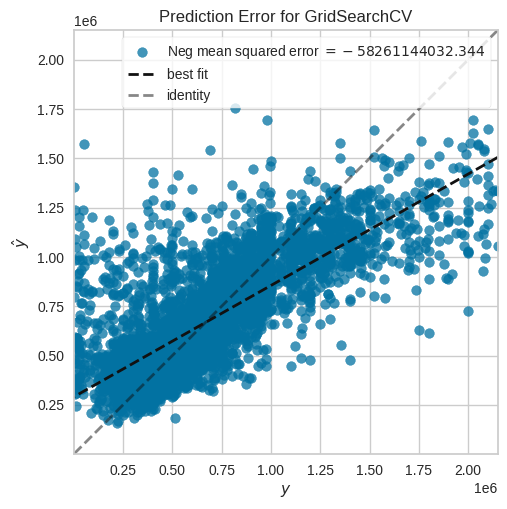

In [25]:
model = grid_em
visualizer = PredictionError(model)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer
visualizer.show();

Let's try another model; Random Forest.

With random forest we can use ordinal encoder. So We will do data preparation again. 

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
column_trans_rf = make_column_transformer( (ord_enc, cat),
                                        (StandardScaler(), num),
                                        remainder='passthrough'
                                      )
    

X_train = column_trans_rf.fit_transform(X_train)

X_test = column_trans_rf.transform(X_test)

In [27]:
rf_model = RandomForestRegressor(random_state=101, n_jobs=-1)

rf_model.fit(X_train,y_train)

train_val(rf_model, X_train, y_train, X_test, y_test)


,train,test
R2,9.182269e-01,5.521772e-01
mae,6.739020e+04,1.670364e+05
mse,1.081706e+10,6.214233e+10
rmse,1.040051e+05,2.492836e+05


Above we see that train error is very low when we compare it to test error. There is an be overfiting. 

Let's this time change the parameters of random forest model manually. We will try to reduce max depth to manage overfiting.

In [28]:
rf_model = RandomForestRegressor(random_state=101, max_depth = 10, n_estimators=150, n_jobs=-1)

rf_model.fit(X_train,y_train)
rf_model_results = train_val(rf_model, X_train, y_train, X_test, y_test )
rf_model_results.columns= ["rf_train", "rf_test"]
rf_model_results

,rf_train,rf_test
R2,5.919371e-01,5.110298e-01
mae,1.581284e+05,1.766518e+05
mse,5.397913e+10,6.785217e+10
rmse,2.323341e+05,2.604845e+05


Above we see that train and test errors approached each other.

Below we will look at the feature importance.

In [29]:
feature_names = list(X.select_dtypes("object").columns) + list(X.select_dtypes("number").columns)
feature_names

['NEIGHBORHOOD',
 'BUILDING_CLASS_CATEGORY',
 'TAX_CLASS_AT_PRESENT',
 'TAX_CLASS_AT_TIME_OF_SALE',
 'BUILDING_CLASS_AT_PRESENT',
 'BUILDING_CLASS_AT_TIME_OF_SALE',
 'BOROUGH_NAME',
 'RESIDENTIAL_UNITS',
 'COMMERCIAL_UNITS',
 'TOTAL_UNITS',
 'LAND_SQUARE_FEET',
 'GROSS_SQUARE_FEET',
 'AGE']

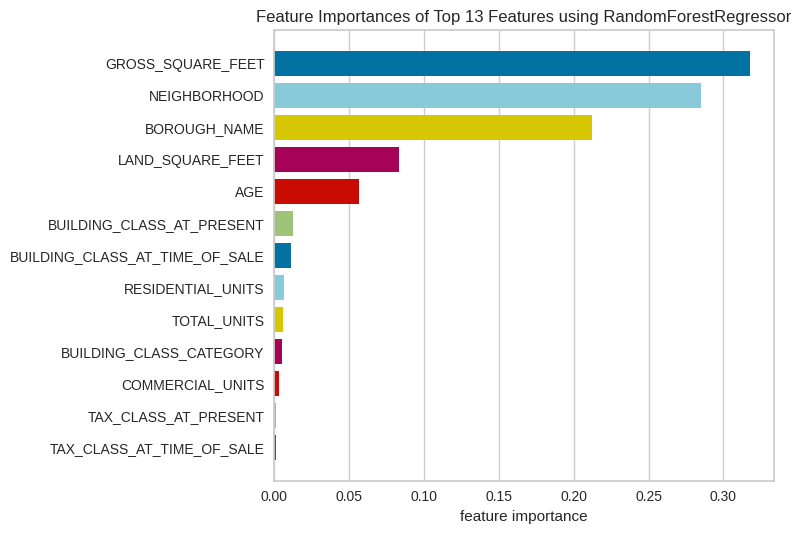

In [30]:
model = rf_model
visualizer = FeatureImportances(model, labels= feature_names, relative= False, topn= 13 )
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();

Above plot shows that most important features are GROSS_SQUARE_FEET, NEIGHBORHOOD, BOROUGH_NAME and, LAND_SQUARE_FEET.

In [31]:
xgb_model = XGBRegressor(random_state=101)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=101, ...)

In [32]:
xgb_model_results = train_val(xgb_model, X_train, y_train, X_test, y_test )
xgb_model_results

,train,test
R2,7.524687e-01,5.837541e-01
mae,1.237938e+05,1.614793e+05
mse,3.274379e+10,5.776055e+10
rmse,1.809524e+05,2.403342e+05


In [33]:
xgb_model = XGBRegressor(max_depth=3, n_estimators=50,  random_state=101)
xgb_model.fit(X_train, y_train)

xgb_model_results = train_val(xgb_model, X_train, y_train, X_test, y_test )
xgb_model_results.columns = ["xgb_train", "xgb_test"]
xgb_model_results

,xgb_train,xgb_test
R2,5.261265e-01,5.099902e-01
mae,1.716777e+05,1.783823e+05
mse,6.268465e+10,6.799644e+10
rmse,2.503690e+05,2.607613e+05


In [34]:
param_grid = {"n_estimators":[100, 150, 200, 250, 300,],
              "max_depth":[2, 3, 4],
              "learning_rate": [0.01, 0.05, 0.1]
              }

In [35]:
xgb_model = XGBRegressor(random_state=101)
grid_xgb = GridSearchCV(estimator=xgb_model,
                          param_grid=param_grid,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=2,
                          n_jobs=-1)

In [36]:
grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=101, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [100, 150, 200, 250, 300]},
             scoring='neg_mean_squared_error', verbose=2)

In [37]:
grid_xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}

In [38]:
train_val(grid_xgb,  X_train, y_train, X_test, y_test )

,train,test
R2,6.398796e-01,5.741591e-01
mae,1.481132e+05,1.632806e+05
mse,4.763723e+10,5.909201e+10
rmse,2.182596e+05,2.430885e+05


Comparing the models

In [39]:
all_results = pd.concat([elastic_model_results, rf_model_results, xgb_model_results], axis=1)
all_results

,em_train,em_test,rf_train,rf_test,xgb_train,xgb_test
R2,5.774317e-01,5.801466e-01,5.919371e-01,5.110298e-01,5.261265e-01,5.099902e-01
mae,1.571698e+05,1.608417e+05,1.581284e+05,1.766518e+05,1.716777e+05,1.783823e+05
mse,5.589793e+10,5.826114e+10,5.397913e+10,6.785217e+10,6.268465e+10,6.799644e+10
rmse,2.364274e+05,2.413735e+05,2.323341e+05,2.604845e+05,2.503690e+05,2.607613e+05


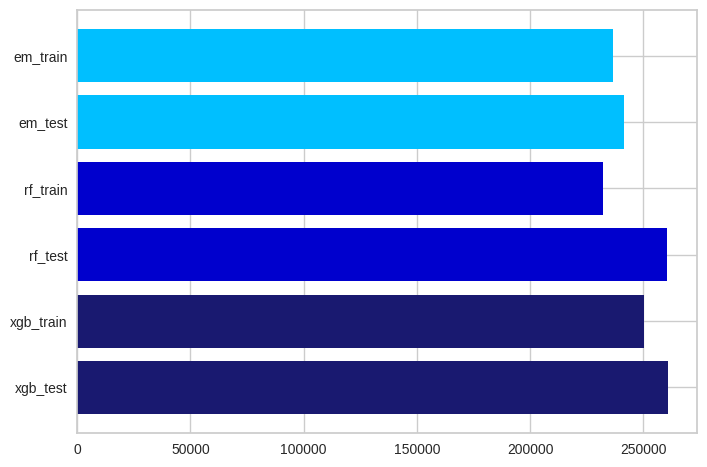

In [40]:
fig, ax = plt.subplots()
x = all_results.T["rmse"][::-1].index
y = all_results.T["rmse"][::-1].values
bar_colors = ['midnightblue', 'midnightblue', "mediumblue", 'mediumblue', 'deepskyblue', 'deepskyblue', ];
ax.barh(x, width=y , color=bar_colors);


We decided to choose elasticNet model. Now we will train the model again with the whole data and save it.

We will build our final model with pipeline. By doing in this way we will not need data preparing when we predicting new values. Data preparing will be embedded in pipeline.

In [41]:
grid_em.best_params_

{'alpha': 50, 'l1_ratio': 1}

In [42]:
X = df.drop("SALE_PRICE", axis=1)
y = df["SALE_PRICE"]

In [43]:
operations = [("OneHotEncoder_StandardScaler", column_trans_em), ("ElasticNet_model", ElasticNet(alpha= 50, l1_ratio=1))]

final_model = Pipeline(steps=operations)

In [44]:
final_model.fit(X, y)

Pipeline(steps=[('OneHotEncoder_StandardScaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_PRESENT',
       'BUILDING_CLASS_AT_TIME_OF_SALE', 'BOROUGH_NAME'],
      dtype='object')),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  Index(['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'AGE'],
      dtype='object'))])),
                ('ElasticNet_model', ElasticNet(alpha=50, l1_ratio=1))])

In [45]:
pickle.dump(final_model, open("NYC_sales_pred_model", 'wb')) 


In [46]:
loaded_model = pickle.load(open("NYC_sales_pred_model", "rb"))

X = df.drop("SALE_PRICE", axis=1)

In [53]:
index = 101

test = X.iloc[[index]]

print(f"{y.iloc[index]} is real value for index {index} ")
    

290000.0 is real value for index 101 


In [54]:
pred = round(
        loaded_model.predict(test)[0],
    0)

print(f"{pred} is the prediction for index {index}")

234798.0 is the prediction for index 101
